In [1]:
rating_df = pd.read_csv('data/ratings.csv')

print(rating_df.shape)
rating_df.head(3)

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [2]:
rating_df.rating.describe()

count    2.500010e+07
mean     3.533854e+00
std      1.060744e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

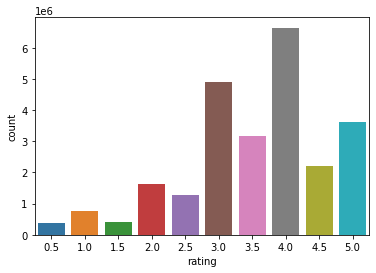

In [3]:
sns.countplot(rating_df.rating);

In [4]:
# 유저 수는 약 162000명, 영화 수는 약 59000개 이다.
print(f"Users : {rating_df.userId.nunique()}")
print(f"Movies : {rating_df.movieId.nunique()}")

Users : 162541
Movies : 59047


In [5]:
# 한 유저가 같은 영화에 대해 두 번 이상 평점을 매긴 경우는 존재하지 않는다.
rating_df.groupby(['userId', 'movieId']).size().value_counts()

1    25000095
dtype: int64

In [6]:
# 해당 데이터는 한 유저가 최소 20개에서부터 최대 약 32000개의 영화에 대해 평점을 매긴 데이터이다.
rating_df.groupby('userId')['movieId'].count().sort_values()

userId
56219        20
87801        20
129589       20
57943        20
129586       20
          ...  
20055      7488
33844      7919
137293     8913
80974      9178
72315     32202
Name: movieId, Length: 162541, dtype: int64

In [7]:
# 한 명의 유저에게 평가받은 영화는 10298개, 두 명의 유저에게 평가받은 영화는 7633개 ... 로 이루어져 있다.
rating_df.groupby('movieId')['userId'].count().value_counts()

1        10298
2         7633
3         4923
4         3473
5         2513
         ...  
4527         1
2508         1
6638         1
10760        1
14329        1
Name: userId, Length: 3820, dtype: int64

---

---

In [8]:
filter_movies = rating_df.movieId.value_counts() > 100
filter_movies = filter_movies[filter_movies].index.tolist()

filter_users = rating_df.userId.value_counts() > 50
filter_users = filter_users[filter_users].index.tolist()

filtered_df = rating_df[
    (rating_df['userId'].isin(filter_users)) & (rating_df['movieId'].isin(filter_movies))
]

print(f"필터링 전 데이터 수 :{len(rating_df)}")
print(f"필터링 후 데이터 수 :{len(filtered_df)}")

del filter_movies, filter_users

필터링 전 데이터 수 :25000095
필터링 후 데이터 수 :22488390


In [9]:
# Train, Test Dataset Split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(filtered_df, random_state=13)

del filtered_df

In [10]:
# 101074명 - 10291 영화에 대한 interaction matrix 생성
pivot_df = pd.pivot_table(train_df, index='userId', columns='movieId', values='rating')

print(pivot_df.shape)
pivot_df.head(2)

(101074, 10291)


movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# 상품-유저 인터랙션 행렬 : 결측값에 대해 0으로 채운
temp_df = pivot_df.copy().fillna(0).T
temp_df.head(2)

userId,1,2,3,4,5,8,9,10,12,13,...,162530,162532,162533,162534,162535,162536,162537,162538,162540,162541
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3.5,4.0,3.0,0.0,0.0,0.0,3.5,0.0,4.0,...,0.0,0.0,4.5,4.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# 유사도 행렬을 구하기 위해 결측값을 각 유저별 평균 평점으로 대체
pivot_df = pivot_df.T.fillna(pivot_df.mean(axis=1)).T
pivot_df.head(2)

movieId,1,2,3,4,5,6,7,8,9,10,...,202103,202393,202429,202439,203222,203519,204352,204542,204698,205383
userId,,,,,,,,,,,,,,,,,,,,,
1,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,...,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077,3.923077
2,3.500000,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,...,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839,3.660839


# 상품 중심 협업 필터링 진행

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# 유저-영화 행렬을 영화-유저 행렬로 전치(transpose)한다.
pivot_df_T = pivot_df.T

In [16]:
# 영화-영화 유사도 행렬
n_similar_movies = 10
item_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

In [15]:
%%time
n_similar_movies = 10
item_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

rating_prediction_dfs = []
for movie_id in test_df['movieId'].unique():
    # 영화-유저 인터랙션 행렬에서 해당 movie의 인덱스 추출
    movie_idx = np.where(pivot_df_T.index == movie_id)[0].tolist()[0]
    
    # 해당 movie에 대해 자신의 제외한 모든 영화의 유사도 벡터 추출
    similarities = item_cosine_matrix[movie_idx]
    similarities = pd.Series(similarities, index=pivot_df_T.index)
    similarities.drop(index=movie_id, inplace=True)
    
    # 해당 movie의 상위 10개의 유사 영화 리스트 추출
    n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]
    
    # Test Dataset에서 해당 movie를 본 userId 추출
    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    # 상품-유저 행렬에서 상위 10개의 유사 영화에 대해 test_users가 평점을 준 행렬 추출
    n_ratings = pivot_df_T.loc[n_similarities.index, test_users]
    
    # test_users가 상위 10개의 유사 영화들에 대해 평가한 평점과 유사도를 이용해 가중 평균을 통해 각 test_user마다 해당 movie의 예측평점 도출
    weighted_n_ratings = n_ratings.multiply(n_similarities, axis='index')
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    
    # 해당 movie에 대한 test_users의 예측 평점 데이터프레임 생성 후 전체 예측 데이터프레임에 추가
    scores_df = scores.rename('prediction').reset_index().assign(movie_id=movie_id)
    rating_prediction_dfs.append(scores_df)

CPU times: user 15min 3s, sys: 1min 6s, total: 16min 10s
Wall time: 4min 32s


In [19]:
movie_pred_df = pd.concat(rating_prediction_dfs).set_index(['userId', 'movie_id'])
movie_pred_df = test_df.rename({'movieId': 'movie_id'}, axis=1).set_index(['userId', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
userId,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [21]:
from sklearn.metrics import mean_squared_error

y_true = movie_pred_df.rating.values
y_pred = movie_pred_df.prediction.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE of recommendation by item-item collaborative filtering:", rmse)

RMSE of recommendation by item-item collaborative filtering: 0.9473424478079131


### 개선된 모델 로직

In [15]:
%%time
item_cosine_matrix = cosine_similarity(pivot_df_T, pivot_df_T)

n_similar_movies = 10
test_length = int(test_df.movieId.nunique())

ratings_prediction_dfs = []
for num, movie_id in enumerate(test_df.movieId.unique()):
    if num in np.linspace(0, test_length, 11).astype(int).tolist()[1:]:
        print(f"Completed {int(np.round((num / test_length), 1) * 100)}%")
    movie_idx = np.where(pivot_df_T.index == movie_id)[0].tolist()[0]
    
    similarities = (
        pd.Series(item_cosine_matrix[movie_idx], index=pivot_df_T.index)
        .drop(movie_id, axis=0)
    )

    n_similarities = similarities.sort_values(ascending=False)[:n_similar_movies]

    test_users = test_df.loc[test_df['movieId'] == movie_id, 'userId']
    
    test_m_u = temp_df.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)

    weighted_n_ratings = pivot_df_T.loc[n_similarities.index, test_users].multiply(n_similarities, axis=0)
    scores = weighted_n_ratings.sum(axis=0) / n_similarities.sum()
    temp_score_dict = {'user_id': [], 'prediction': []}
    for user_id in test_m_u.columns:
        temp_idx = np.where(test_m_u.loc[:, user_id].values != 0.0)[0]

        temp_score_dict['user_id'].append(user_id)
        # temp_idx가 None이면
        # test_users가 상위 10개의 유사 영화들에 대해 평가한 평점과 유사도를 이용해 가중 평균을 통해 각 test_user마다 해당 movie의 예측평점 도출
        if len(temp_idx) == 0:
            temp_score_dict['prediction'].append(scores.loc[user_id])
        else:
            weighted_n_ratings_val = [test_m_u.loc[:, user_id].values[idx] for idx in temp_idx]
            n_similarities_val = [n_similarities.values[idx] for idx in temp_idx]
            
            score = np.sum(weighted_n_ratings_val) / np.sum(n_similarities_val)
            temp_score_dict['prediction'].append(score)

    score_df = pd.DataFrame(temp_score_dict).assign(movie_id=movie_id)
    ratings_prediction_dfs.append(score_df)

Completed 10%
Completed 20%
Completed 30%
Completed 40%
Completed 50%
Completed 60%
Completed 70%
Completed 80%
Completed 90%
CPU times: user 31min 58s, sys: 2h 3min 39s, total: 2h 35min 38s
Wall time: 3h 43min 4s


In [16]:
movie_pred_df = pd.concat(ratings_prediction_dfs).set_index(['user_id', 'movie_id'])
movie_pred_df = test_df.rename({'userId': 'user_id', 'movieId': 'movie_id'}, axis=1).set_index(['user_id', 'movie_id']).join(movie_pred_df)
movie_pred_df.head(3)

,,rating,timestamp,prediction
user_id,movie_id,,,
48065,160,3.0,864946735,3.647059
15290,1394,4.0,1111616642,3.635613
128110,4799,2.5,1107336422,3.286269


In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
y_true = movie_pred_df.rating.values
y_pred = movie_pred_df.prediction.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print("RMSE of recommendation by item-item collaborative filtering:", rmse)

RMSE of recommendation by item-item collaborative filtering: 0.9494665308953931


#### 모델 개선 아이디어에 대해
- 아이디어가 나왔을 때 모델 전체를 개선하는 것이 아닌, 샘플 데이터를 추출해 시뮬레이션을 진행해보고 실제값에 좀 더 근접해질 가능성이 보여 진행

#### 유저 중심 협업 필터링 모델에 대해
- 코사인 유사도 대신 자카드 유사도로 유사도 행렬을 도출하는 방법도 존재
    - 이진화 기준 : 각 유저의 평균 평점 이하의 평점은 가졌으면 0, 이상의 평점을 가졌으면 1로 이진화
    

### 결과
- 해당 상품 중심 협업 필터링을 통한 추천 모델은 약 1점정도의 예측오차가 존재한다.
- 추천 방식 : 특정 영화에 대해 높은 예측 평점을 보인 유저들에게 해당 영화를 추천하는 방식
- 개선 방식 : 결측값을 평균으로 대체해 사용하는 것이 아니라 유사 영화들을 정말로 본 유저들의 평점만 사용하는 것이 어떨까?

### 빈발 패턴 분석도 진행
- 유저별 본 movie list에 대한 데이터프레임을 생성하여 진행
    - 추천 모델이므로 평점을 4점 이상 받은 영화에 대해서만 진행